In [109]:
import psycopg2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import collections
from util import build_sequences, build_dataset, to_one_hot
from keras.layers import Dense, Input
from keras.models import Model
from sklearn.utils import shuffle
import tensorflow as tf
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN, KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.decomposition import PCA
%matplotlib inline

plt.style.use('ggplot')

# Relavant Tables
Procedure timeseries mimic III tables that could be used in critical care pathway discovery and modelling

- [procedures_icd](https://mimic.physionet.org/mimictables/procedures_icd/): (240,095) Contains ICD procedures for patients, most notably ICD-9 procedures
    - links to [d_icd_procedures](https://mimic.physionet.org/mimictables/d_icd_procedures/) (3,882) on ICD9_CODE
- [chartevents](https://mimic.physionet.org/mimictables/chartevents/): (330,712,483) all data for all patients
- [cptevents](https://mimic.physionet.org/mimictables/cptevents/): (573146) Contains current procedural terminology (CPT) codes, which facilitate billing for procedures performed on patients.
- [procedureevents_mv](https://mimic.physionet.org/mimictables/procedureevents_mv/): (258,066) Contains procedures for patients
- [labevents](https://mimic.physionet.org/mimictables/labevents/): (27,854,055) Contains all laboratory measurements for a given patient, including out patient data.
- [noteevents](https://mimic.physionet.org/mimictables/noteevents/): (2,083,180) Contains all notes for patients.

# PROCEDURES_ICD Analysis

## TODO:
- ~~mimic queries~~
- ~~mapping functions for procedures to one-hot vectors~~
- ~~construct skip grams~~
- ~~train embedding model~~
- ~~TSNE visualization~~
- ~~clustering~~
- ~~clustering metrics (purity / silhouette)~~
- ~~reverse mapping to procedure descriptions~~
- Procedure sequence trajectories
- spark parallelization of bottlenecks
    - queries, preprocessing
    - t-SNE
    - clustering
    - embedding model training?
- noise contrastive estimation?
- revisit RNN/LSTMs embeddings?

In [ ]:
sqluser = 'mwalton'
dbname = 'mimic'
schema_name = 'mimiciii'

connection = psycopg2.connect(dbname=dbname, user=sqluser)
cursor = connection.cursor()
cursor.execute('SET search_path to {}'.format(schema_name))

In [152]:
# build a mapper from icd9s to descriptoins
query = '''SELECT icd9_code, short_title, long_title
        FROM d_icd_procedures'''

d_procedures = pd.read_sql_query(query, connection)

In [154]:
procedure_description_dict = {}
for r in d_procedures.itertuples(index=False):
    procedure_description_dict[r.icd9_code] = (r.short_title, r.long_title)

In [2]:
# select from procedures, join icd9s with descriptions
query = '''SELECT subject_id, hadm_id, seq_num, procedures_icd.icd9_code, d_icd_procedures.short_title, d_icd_procedures.long_title
        FROM procedures_icd
        LEFT OUTER JOIN d_icd_procedures ON (procedures_icd.icd9_code = d_icd_procedures.icd9_code)
        '''

procedures = pd.read_sql_query(query, connection)
procedures_seq = procedures.set_index(['hadm_id', 'seq_num']).reset_index()
procedures_seq

,hadm_id,seq_num,subject_id,icd9_code,short_title,long_title
0,154460,3,62641,3404,Insert intercostal cath,Insertion of intercostal catheter for drainage
1,130856,1,2592,9671,Cont inv mec ven <96 hrs,Continuous invasive mechanical ventilation for...
2,130856,2,2592,3893,Venous cath NEC,"Venous catheterization, not elsewhere classified"
3,119355,1,55357,9672,Cont inv mec ven 96+ hrs,Continuous invasive mechanical ventilation for...
4,119355,2,55357,0331,Spinal tap,Spinal tap
5,119355,3,55357,3893,Venous cath NEC,"Venous catheterization, not elsewhere classified"
6,158060,1,9545,034,Excis spinal cord lesion,Excision or destruction of lesion of spinal co...
7,189217,1,28600,3613,Aortocor bypas-3 cor art,(Aorto)coronary bypass of three coronary arteries
8,189217,2,28600,3615,1 int mam-cor art bypass,Single internal mammary-coronary artery bypass
9,189217,3,28600,3961,Extracorporeal circulat,Extracorporeal circulation auxiliary to open h...


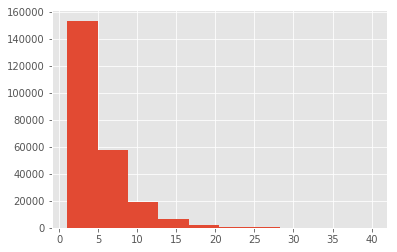

In [3]:
procedures['seq_num'].hist()

In [4]:
vocab_size = np.unique(procedures.icd9_code).size
data, counts, dictionary, inverse_dict = build_sequences(procedures,
                                                         vocab_size,
                                                         min_seq_len=2)

# Maximum likelihood estimation

In [5]:
x_train, y_train = build_dataset(data, vocab_size+1, one_hot=True)

In [35]:
embedding_dim = 32
nb_epoch = 10
batch_size = 64

x = Input(shape=(vocab_size + 1,))
embedding = Dense(embedding_dim)(x)
y_pred = Dense(vocab_size + 1, activation='softmax')(embedding)
model = Model(x, y_pred)
model.compile(optimizer='adam', loss='categorical_crossentropy')

In [36]:
hist = model.fit(x_train, y_train, batch_size=batch_size, nb_epoch=nb_epoch)

/Users/mwalton/miniconda3/envs/gatech/lib/python3.6/site-packages/ipykernel/__main__.py:1: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  if __name__ == '__main__':


Epoch 1/10
370770/370770 [==============================] - 71s 193us/step - loss: 4.4935
Epoch 2/10
370770/370770 [==============================] - 70s 189us/step - loss: 3.9503
Epoch 3/10
370770/370770 [==============================] - 69s 187us/step - loss: 3.8403
Epoch 4/10
370770/370770 [==============================] - 69s 185us/step - loss: 3.7891
Epoch 5/10
370770/370770 [==============================] - 68s 185us/step - loss: 3.7588
Epoch 6/10
370770/370770 [==============================] - 69s 186us/step - loss: 3.7376
Epoch 7/10
370770/370770 [==============================] - 68s 183us/step - loss: 3.7216
Epoch 8/10
370770/370770 [==============================] - 71s 192us/step - loss: 3.7092
Epoch 9/10
370770/370770 [==============================] - 70s 189us/step - loss: 3.6991
Epoch 10/10
370770/370770 [==============================] - 69s 186us/step - loss: 3.6908


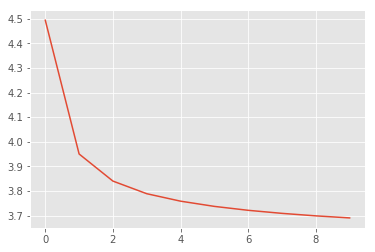

In [48]:
plt.plot(hist.history['loss'])

In [49]:
embed = Model(x, embedding)
x_embed = embed.predict(x_train)

NB clusters: 151


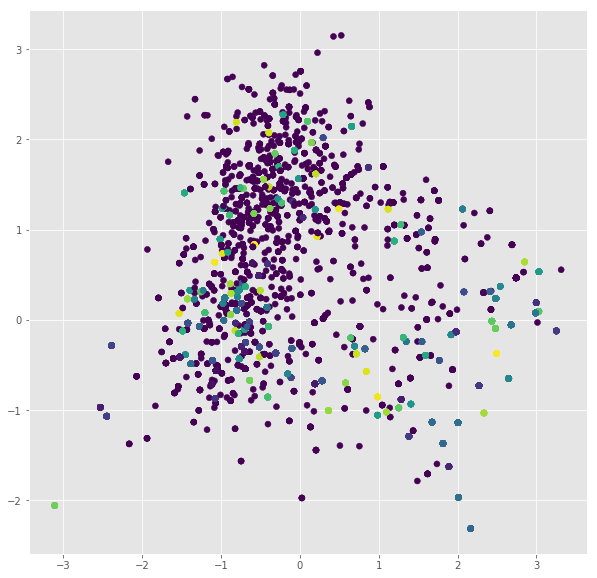

In [119]:
# dim reduce
train_idx = np.random.randint(0, x_embed.shape[0], 10000)
pca = PCA(n_components=2).fit(x_embed[train_idx, :])
low_dim_embeds_pca = pca.transform(x_embed[train_idx, :])

# cluster
rescaled = StandardScaler().fit_transform(x_embed[train_idx, :])
db = DBSCAN(eps=1.5, min_samples=10).fit(rescaled)
labels = db.labels_
print("NB clusters:", len(np.unique(labels)))

# plot
plt.figure(figsize=(10,10))
plt.scatter(low_dim_embeds_pca[:,0], low_dim_embeds_pca[:,1], c=labels)

In [125]:
train_idx = np.random.randint(0, x_embed.shape[0], 1000)
tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=500)
low_dim_embeds = tsne.fit_transform(x_embed[train_idx, :])

In [163]:
rescaled = StandardScaler().fit_transform(x_embed[train_idx, :])
db = DBSCAN(eps=.15, min_samples=10).fit(rescaled)
labels = db.labels_
print("NB clusters: ", len(np.unique(labels)))

NB clusters:  24


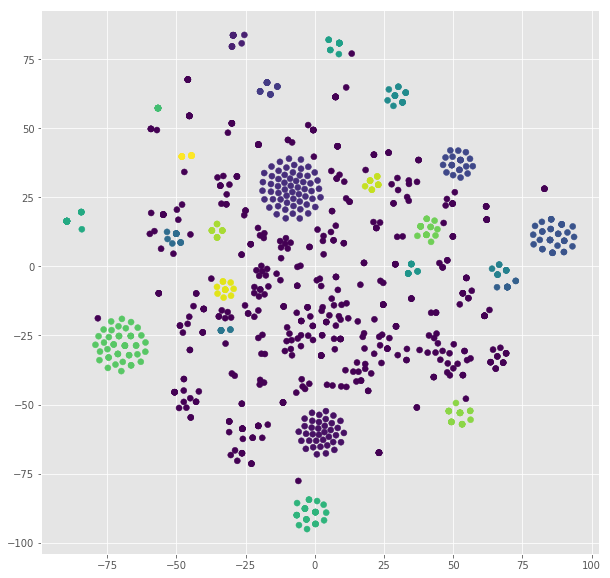

In [164]:
plt.figure(figsize=(10,10))
plt.scatter(low_dim_embeds[:,0], low_dim_embeds[:,1], c=labels)

In [132]:
silhouette_avg = silhouette_score(rescaled, labels)
sample_silhouette_values = silhouette_samples(rescaled, labels)

print("Silhouette Score: {}".format(silhouette_avg))

Silhouette Score: 0.3529360592365265


In [158]:
vocab_ids = np.argmax(x_train[train_idx], axis=1)
icd9s = [inverse_dict[vid] for vid in vocab_ids]
descriptions = [procedure_description_dict[icd] for icd in icd9s] # TODO: inner join to remove invalid icd9s

KeyError: '3601'

In [177]:
# show whats in each cluster, look for semantic similarities between procedures
for i in range(len(np.unique(labels)) - 1):
    in_cluster_samples = np.array(icd9s)[labels == i]
    print("CLUSTER %d | NB SAMPLES: %d" % (i, len(in_cluster_samples)))
    for s in in_cluster_samples:
        print(procedure_description_dict.get(s)[0])

CLUSTER 0 | NB SAMPLES: 37
Cont inv mec ven 96+ hrs
Cont inv mec ven 96+ hrs
Cont inv mec ven 96+ hrs
Cont inv mec ven 96+ hrs
Cont inv mec ven 96+ hrs
Cont inv mec ven 96+ hrs
Cont inv mec ven 96+ hrs
Cont inv mec ven 96+ hrs
Cont inv mec ven 96+ hrs
Cont inv mec ven 96+ hrs
Cont inv mec ven 96+ hrs
Cont inv mec ven 96+ hrs
Cont inv mec ven 96+ hrs
Cont inv mec ven 96+ hrs
Cont inv mec ven 96+ hrs
Cont inv mec ven 96+ hrs
Cont inv mec ven 96+ hrs
Cont inv mec ven 96+ hrs
Cont inv mec ven 96+ hrs
Cont inv mec ven 96+ hrs
Cont inv mec ven 96+ hrs
Cont inv mec ven 96+ hrs
Cont inv mec ven 96+ hrs
Cont inv mec ven 96+ hrs
Cont inv mec ven 96+ hrs
Cont inv mec ven 96+ hrs
Cont inv mec ven 96+ hrs
Cont inv mec ven 96+ hrs
Cont inv mec ven 96+ hrs
Cont inv mec ven 96+ hrs
Cont inv mec ven 96+ hrs
Cont inv mec ven 96+ hrs
Cont inv mec ven 96+ hrs
Cont inv mec ven 96+ hrs
Cont inv mec ven 96+ hrs
Cont inv mec ven 96+ hrs
Cont inv mec ven 96+ hrs
CLUSTER 1 | NB SAMPLES: 18
Parent infus nutrit s

# Noise Contrastive Estimation
see: 
- https://www.tensorflow.org/tutorials/word2vec
- https://github.com/tensorflow/tensorflow/blob/r1.4/tensorflow/examples/tutorials/word2vec/word2vec_basic.py
- https://datascience.stackexchange.com/questions/13216/intuitive-explanation-of-noise-contrastive-estimation-nce-loss

In [17]:
x_train, y_train = build_dataset(data, vocab_size+1, one_hot=False)

In [ ]:
# construct the skip-gram model using noise contrastive estimation (NCE)
embedding_dim = 2
num_sampled = 64 # Noise samples per positive example
nb_iter = 1000
batch_size = 128

graph = tf.Graph()
with graph.as_default():
    x = tf.placeholder(tf.int32, shape=(batch_size))
    y = tf.placeholder(tf.int32, shape=(batch_size, 1))

    e_params = tf.Variable(tf.random_uniform([vocab_size + 1, embedding_dim], -1.0, 1.0))
    embedding = tf.nn.embedding_lookup(e_params, x)

    W = tf.Variable(tf.truncated_normal([vocab_size + 1], stddev=1.0 / np.sqrt(embedding_dim)))
    b = tf.Variable(tf.zeros([vocab_size + 1]))

    loss = tf.reduce_mean(tf.nn.nce_loss(W, b, labels=y,
                                         inputs=embedding,
                                         num_sampled=num_sampled,
                                         num_classes=vocab_size+1))

    optimizer = tf.train.GradientDescentOptimizer(1.0).minimize(loss)

    init = tf.global_variables_initializer()